## Modelo Pronóstico Oceanic Niño Index (ONI) - Pantaleon Sugar Holdings


**El Niño (La Niña)** es un fenómeno en el Océano Pacífico Ecuatorial caracterizado por una media móvil consecutiva trimestral de anomalías en la temperatura superficial del océano (Sea Surface Temperature o SST) en la *región Niño 3.4* que está por arriba (o por debajo) del umbral de +0.5°C (-0.5°C). A éste estándar de medición se le conoce como el **Índice Océanico del Niño** (Oceanic Niño Index ONI).

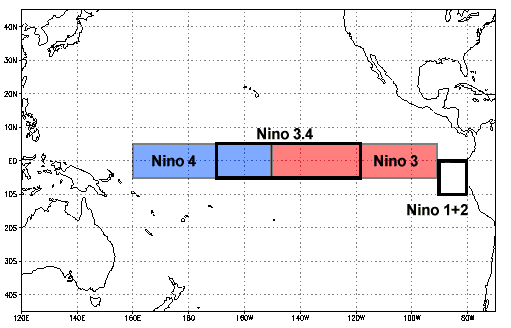


Se presenta un modelo de Deep Learning para el pronóstico del valor de Índice Oceánico de El Niño, que representa el índice que traza el patrón climático de la zona océanica ENSO (ver referencias abajo). El ONI es la media móvil trimestral de las anomalías (diferencias respecto a la media) en la superficie de la región centro-oriental tropical del océano Pacífico, cercana a la línea internacional del cambio de fecha.

*   https://ggweather.com/enso/oni.htm
*   https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

El ONI es importante para categorizar los efectos NIÑO o NIÑA en una escala DÉBIL, MODERADA, FUERTE y MUY FUERTE.
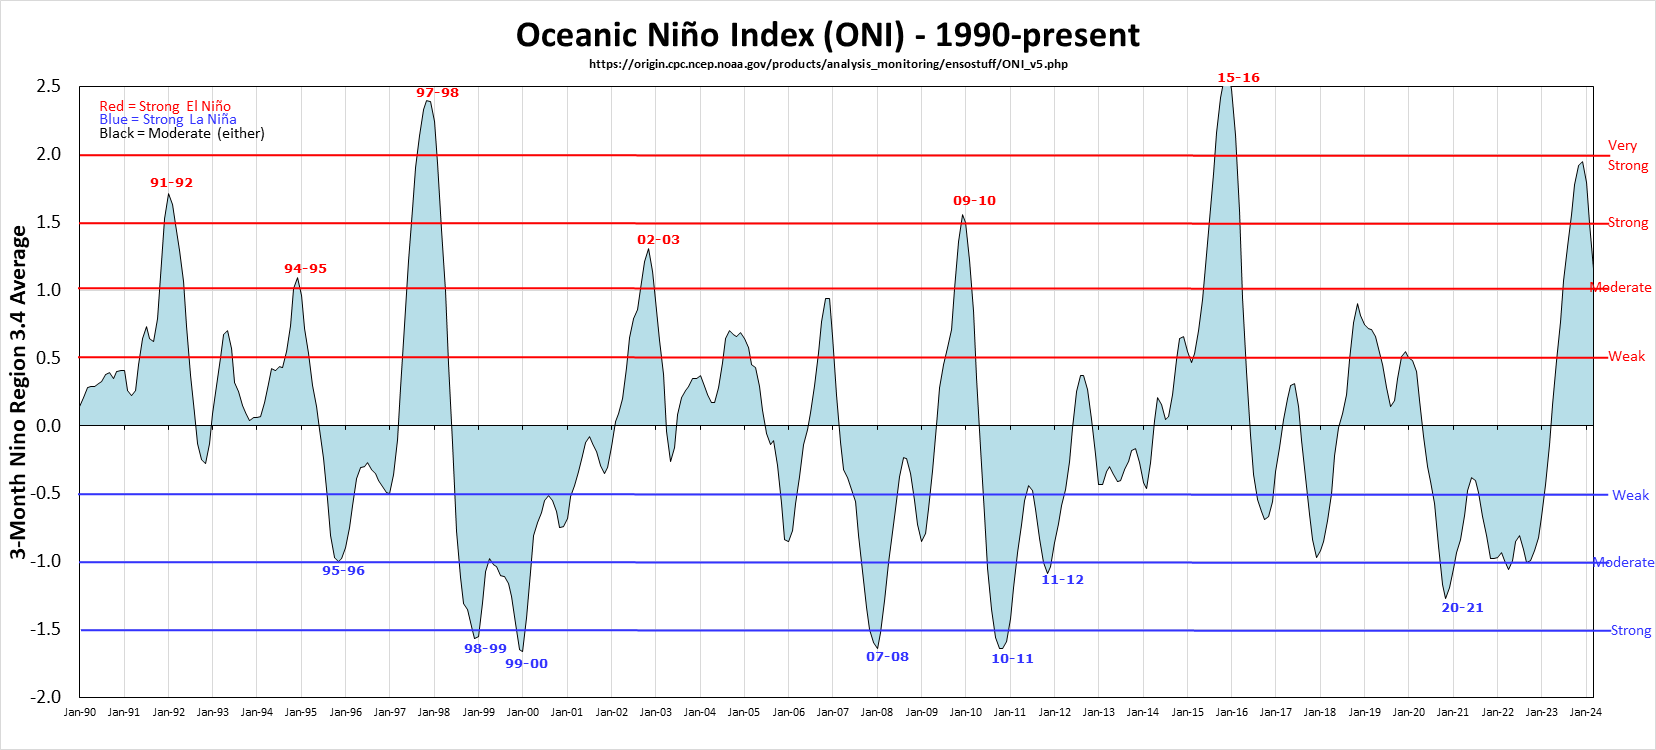
El siguiente trabajo de modelado utiliza una Red Neuronal Recurrente para Series de Tiempo, que permite pronosticar futuros valores del ONI por mes. Este modelamiento se realiza sobre los datos registrados del ONI desde el año 1950 por el National Weather Service del Centro de Predicción Climática (CPC) de los Estados Unidos.

In [1]:
# DS Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

# Deep Learning Framework
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.saving import load_model

#### Dataset Oceanic Niño Index
- https://www.ncei.noaa.gov/access/monitoring/enso/sst
- https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

In [2]:
# .csv de Anomialias ONI
oni_df = pd.read_csv("ONI_2024.csv")
oni_df['Date'] = oni_df['YR'].astype(str)+'-'+(oni_df.index%12 + 1).astype(str)
oni_df.drop(['YR','SEAS','TOTAL'], axis=1, inplace=True)
oni_df.rename(columns = {'ANOM':'ONI'}, inplace = True)
oni_df

,ONI,Date
0,-1.53,1950-1
1,-1.34,1950-2
2,-1.16,1950-3
3,-1.18,1950-4
4,-1.07,1950-5
...,...,...
886,1.92,2023-11
887,1.95,2023-12
888,1.79,2024-1
889,1.49,2024-2


In [3]:
ONI = oni_df.ONI.values.reshape(-1, 1)
ONI.shape

(891, 1)

#### Evaluation Functions

In [4]:
def plot_train_metrics(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [90]:
def plot_predictions(y, predictions):
  predictions = predictions.flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  plt.title('Predictions vrs. Actuals') 
  plt.ylabel('ONI')
  plt.xlabel('month')
  plt.legend(['Predictions', 'Actuals'], loc='upper left')
  return df, mse(predictions, y)

#### Scaling Transform
Se utiliza una transformación tipo MAX-MIN para evitar desvanecimiento de gradientes.



In [5]:
# Escalamiento del ONI
scaler = MinMaxScaler()

# Formateo para el escalador
ONI_train_scaled = scaler.fit_transform(ONI)
ONI_train_scaled.shape

(891, 1)

### Modelo de Recurrencia Multiple-Months-Ahead

Se define la estructura de datos para utilizar en los modelos de recurrencia.

**Multiple-Month-Ahead** es una generalización del modelo One-Month-Ahead que utiliza una Red Neuronal Recurrente (LSTM, GRU o CNN) en la que valores anteriores (determinados por la longitud del horizonte lookback) se utilizan para pronosticar varios valores en el futuro (determinados por la longitud del horizonte forecast). En el ejemplo, se muestra la generalización del modelo para un *lookback* y un *forecast* determinado:

$X_{Month_{n lookback}} = \{ONI_{Month_1},ONI_{Month_2},ONI_{Month_3}, ... , ONI_{Month_{n lookback - 1}}, ONI_{Month_{n lookback}}\}$ 

para pronosticar 

$y_{Month_{n forecast}}=\{ONI_{Month_{n lookback}}, ONI_{Month_{n lookback + 1}}, ... , ONI_{Month_{n forecast - 1}}, ONI_{Month_{n forecast}} \}$

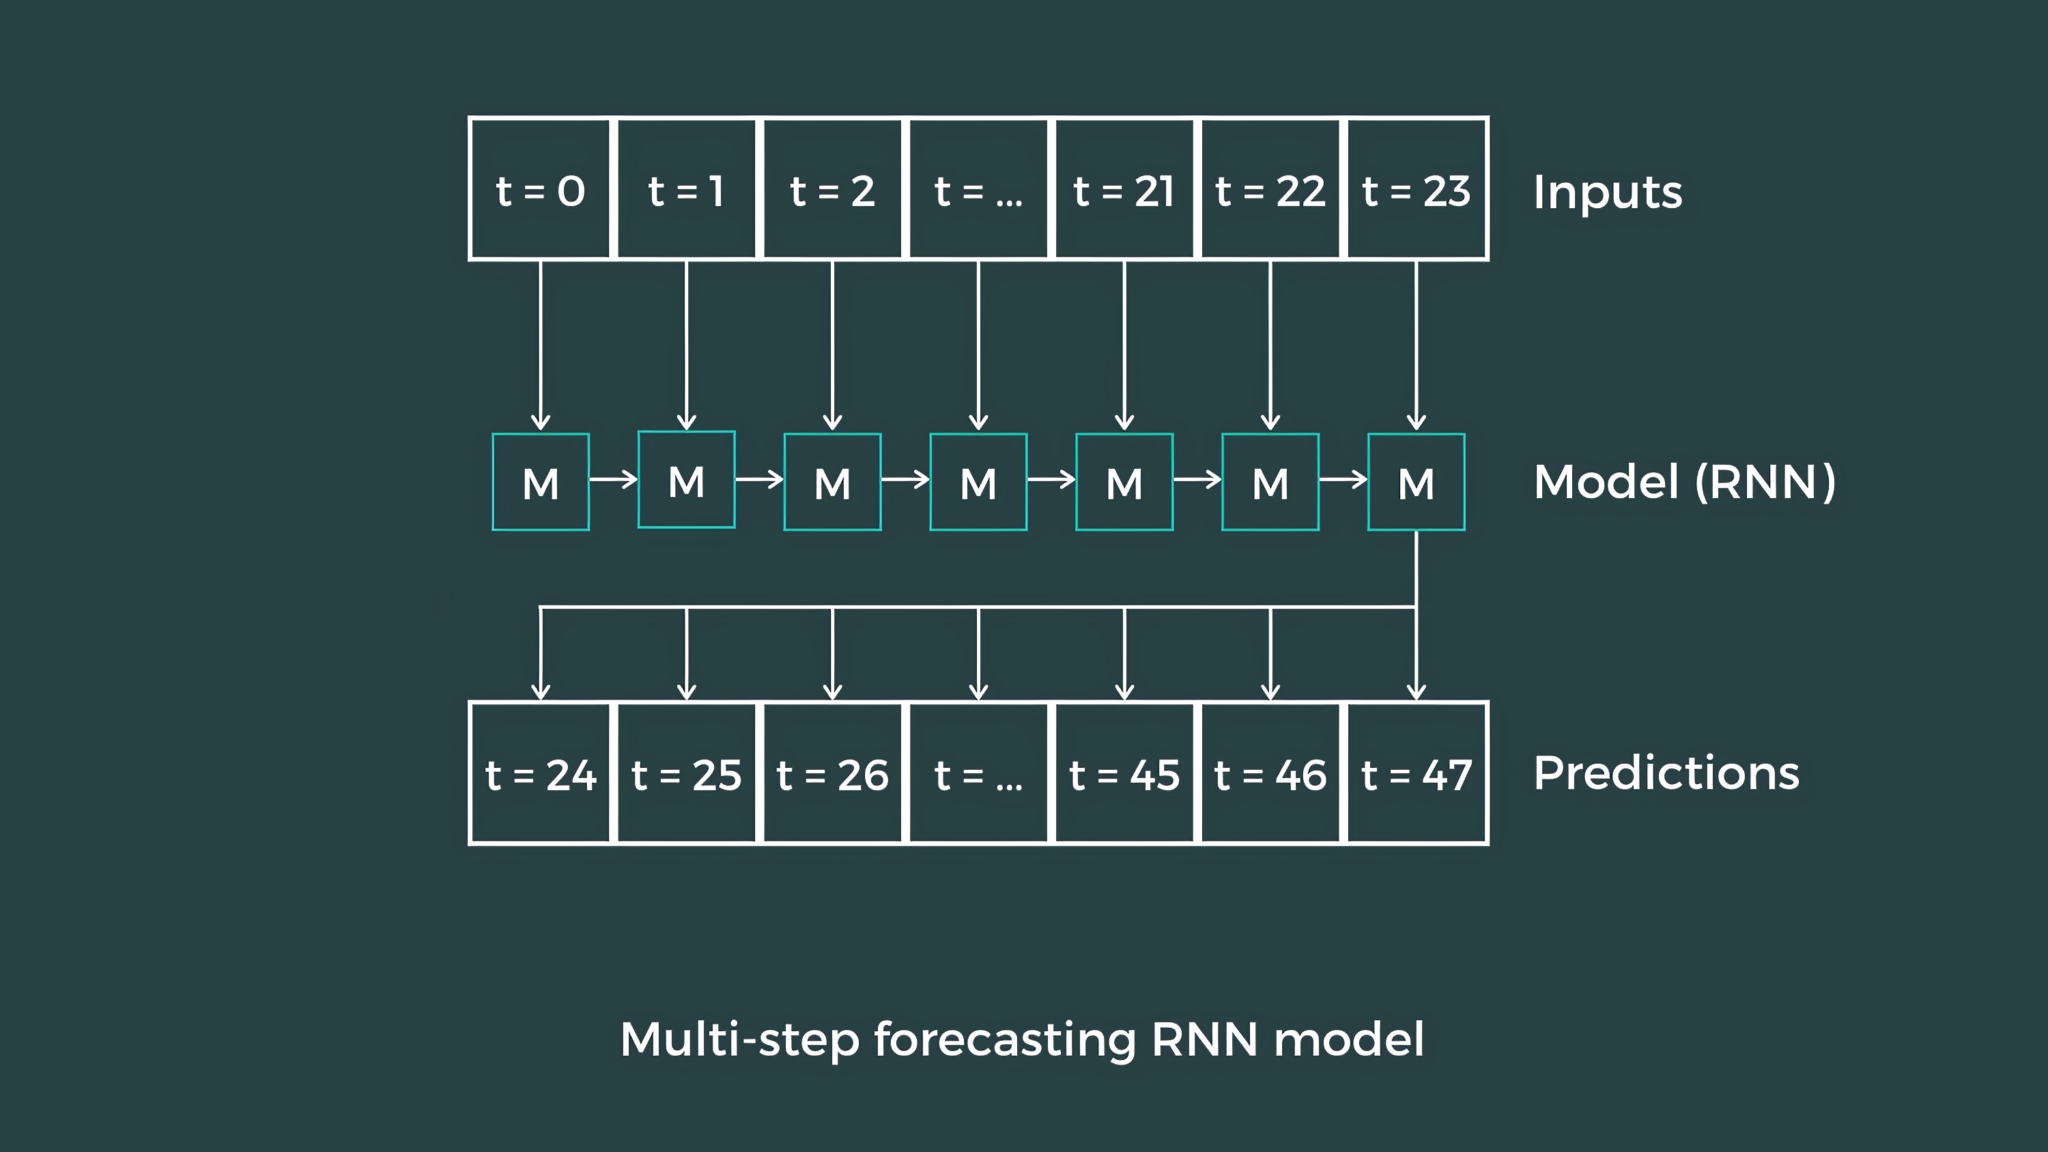

In [161]:
# generate the input and output sequences
n_lookback = 100  # length of input sequences (lookback period)
n_forecast = 6  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(ONI_train_scaled) - n_forecast + 1):
    X.append(ONI_train_scaled[i - n_lookback: i])
    Y.append(ONI_train_scaled[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

### LSTM
https://en.wikipedia.org/wiki/Long_short-term_memory

In [162]:
model1 = Sequential()
model1.add(InputLayer((n_lookback, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(n_forecast, 'linear'))

model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,470 (68.24 KB)

 Trainable params: 17,470 (68.24 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
cp1 = ModelCheckpoint('oni_model_LSTM_MS/checkpoint.model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [164]:
history = model1.fit(X, Y,epochs=50, validation_split=0.2, callbacks=[cp1])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1811 - root_mean_squared_error: 0.4256 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3785
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1487 - root_mean_squared_error: 0.3857 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1224 - root_mean_squared_error: 0.3497 - val_loss: 0.1126 - val_root_mean_squared_error: 0.3356
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1100 - root_mean_squared_error: 0.3317 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3168
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0969 - root_mean_squared_error: 0.3112 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3007
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0878 - root_mean_squared_error: 0.2963 - val_loss: 0.0806 - val_root_mean_squared_error: 0.2838
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss:

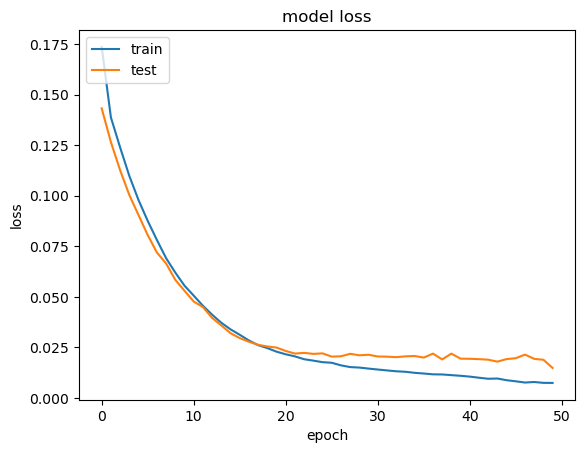

In [165]:
plot_train_metrics(history)

In [166]:
model1 = load_model('oni_model_LSTM_MS/checkpoint.model.keras')

In [169]:
# generate the forecasts

periodo = 6

X_ = ONI_train_scaled[periodo*n_lookback:(periodo+1)*n_lookback]  # secuencia de entrada para el período
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model1.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


#### Plot Predictions

(     Predictions  Actuals
 700    -0.612503    -0.84
 701    -0.640801    -0.61
 702    -0.534102    -0.37
 703    -0.397248    -0.23
 704    -0.313160    -0.24
 705    -0.200492    -0.35,
 0.022551698038213167)

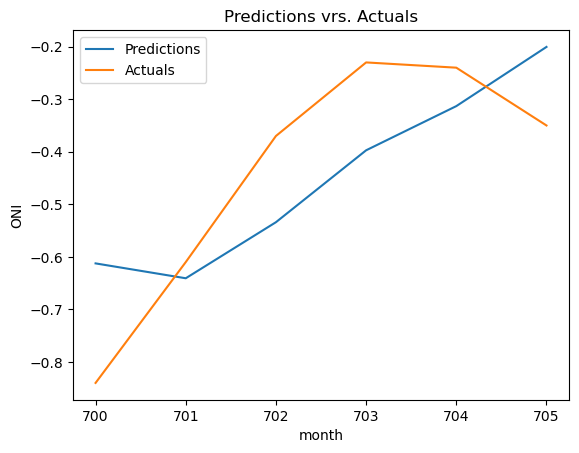

In [170]:
Y_Actuals = oni_df[(periodo+1)*n_lookback:(periodo+1)*n_lookback+n_forecast]['ONI']
plot_predictions(Y_Actuals,Y_)

In [22]:
# organize the results in a data frame
df_past = oni_df
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past.rename(columns={'ONI': 'Actual'}, inplace=True)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_past

/var/folders/r8/vjfpl_c11yj96w72yy_xrcj80000gn/T/ipykernel_1901/2004107791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


,Actual,Date,Forecast
0,-1.53,1950-01-01,NaN
1,-1.34,1950-02-01,NaN
2,-1.16,1950-03-01,NaN
3,-1.18,1950-04-01,NaN
4,-1.07,1950-05-01,NaN
...,...,...,...
886,1.92,2023-11-01,NaN
887,1.95,2023-12-01,NaN
888,1.79,2024-01-01,NaN
889,1.49,2024-02-01,NaN


/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

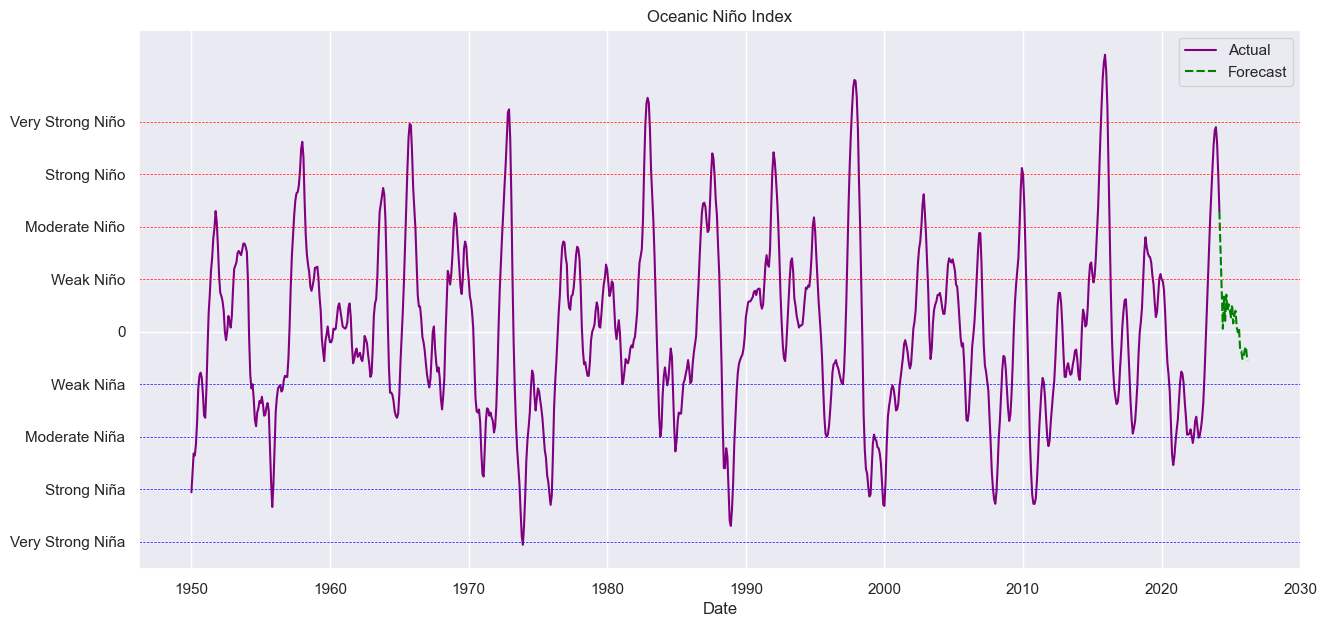

In [23]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
inicio = df_past['Date'].iloc[-1] + pd.DateOffset(months=1)
df_future['Date'] = pd.date_range(start=inicio, periods=n_forecast, freq='M')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan
df_future

# Concatenando Histórico y Predicción a 30 meses
results = pd.concat([df_past,df_future]).set_index('Date')


# Gráfico de Resultados
#results.plot(title='Oceanic Niño Index', figsize = (15,7))
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
plt.figure(figsize=(15,7))
sns.set_style("darkgrid")
graph = sns.lineplot(data = results, palette=['purple', 'green']).set(title='Oceanic Niño Index')

plt.axhline(2.0,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(1.5,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(1.0,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(0.5,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(-0.5,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-1.0,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-1.5,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-2.0,color='blue',linestyle='--',linewidth = 0.5)

plt.yticks([2.0, 1.5, 1.0, 0.5, 0, -2.0, -1.5, -1.0, -0.5], ['Very Strong Niño', 'Strong Niño', 'Moderate Niño', 'Weak Niño','0','Very Strong Niña', 'Strong Niña', 'Moderate Niña', 'Weak Niña'])

plt.show()